In [16]:
import datetime
import pyaurorax
import matplotlib.pyplot as plt
import numpy as np

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Adding contours to CCD images

There are a few functions that help display contour lines on top of individual ASI images (CCD coordinates), facilitated using the `at.ccd_contour` module. In the below sections, we'll have a look at the functions available and the different things you can do with them.

First, we're going to download a minute of TREx RGB data, the skymap, and scale the images.

In [17]:
# download a minute of TREx RGB data from Gillam
dataset_name = "TREX_RGB_RAW_NOMINAL"
dt = datetime.datetime(2023, 2, 24, 6, 15)
site_uid = "gill"
r = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid, progress_bar_disable=True)
data = aurorax.data.ucalgary.read(r.dataset, r.filenames)

# download the corresponding skymap
dataset_name = "TREX_RGB_SKYMAP_IDLSAV"
r = aurorax.data.ucalgary.download_best_skymap(dataset_name, site_uid, dt)
skymap_data = aurorax.data.ucalgary.read(r.dataset, r.filenames).data[0]

# scale the images
scaled_images = at.scale_intensity(data.data, min=15, max=110)

# Add Lines of Constant Elevation and Azimuth

We can draw lines of constant elevation and azimuth on top of an image. We'll pass in the skymap to the function, and the elevation or azimuth value, and then display the image and the contour pixel coordinates using matplotlib.

In [18]:
# Obtain pixel coordinates of the line of 40 degrees elevation
elev_x, elev_y = at.ccd_contour.elevation(skymap_data, 40)

# Obtain pixel coordinates of the line of 45 degrees azimuth
azim_x, azim_y = at.ccd_contour.azimuth(skymap_data, 45)

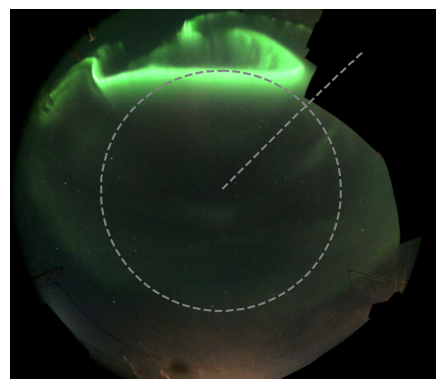

In [19]:
# Display the image
plt.imshow(scaled_images[:, :, :, 0], origin="lower")
plt.axis("off")

# Overplot the lines of constant elevation and azimuth
plt.plot(elev_x, elev_y, color="gray", linestyle="--")
plt.plot(azim_x, azim_y, color="gray", linestyle="--")
plt.show()

Now, let's draw a grid of constant elevation and azimuth contours.

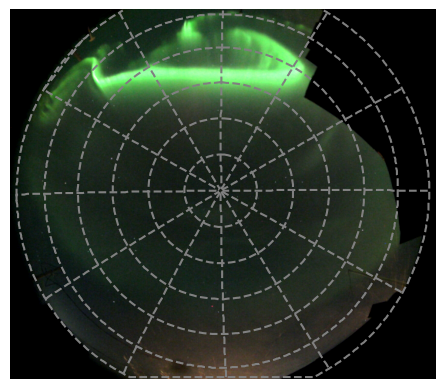

In [20]:
# Create empty lists to hold a number of arrays defining contours
ccd_x = []
ccd_y = []

# Obtain pixel coords for a number of constant elevations
for elevation in range(0, 90, 15):
    elev_x, elev_y = at.ccd_contour.elevation(skymap_data, elevation)
    # add to lists of all ccd coord arrays
    ccd_x.append(elev_x)
    ccd_y.append(elev_y)

# Obtain pixel coords for a number of constant azimuths
for azimuth in range(0, 360, 30):
    azim_x, azim_y = at.ccd_contour.azimuth(skymap_data, azimuth, min_elevation=0)
    # add to lists of all ccd coord arrays
    ccd_x.append(azim_x)
    ccd_y.append(azim_y)

# Plot the image
plt.imshow(scaled_images[:, :, :, 0], origin="lower")
plt.axis("off")

# Iterate through lists and overplot all sets of ccd coords
for i in range(len(ccd_x)):
    plt.plot(ccd_x[i], ccd_y[i], color="gray", linestyle="--")

# Add Geodetic & Geomagnetic Contours

You can also determine contours in geodetic or geomagnetic coordinates. We lean on AACGM to help us with this, and the skymap.

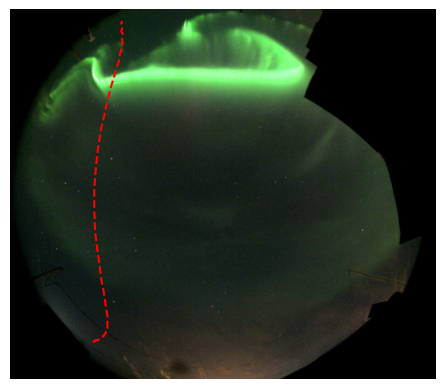

In [21]:
# Custom geodetic contour
# -------------------------
#
# Set altitude we want the contour projected to
altitude_km = 115

# Define some set of geodetic latitudes and longitudes for our contour
latitudes = np.linspace(51.0, 62.0, 50)
longitudes = -102.0 + 5 * np.sin(np.pi * (latitudes - 51.0) / (62.0 - 51.0))

# Get the contour in CCD coordinates
ccd_x, ccd_y = at.ccd_contour.geo(skymap_data, altitude_km, contour_lats=latitudes, contour_lons=longitudes)

# Plot the image
plt.imshow(scaled_images[:, :, :, 0], origin="lower")
plt.axis("off")

# Overplot the contour
plt.plot(ccd_x, ccd_y, color="red", linestyle="--")
plt.show()

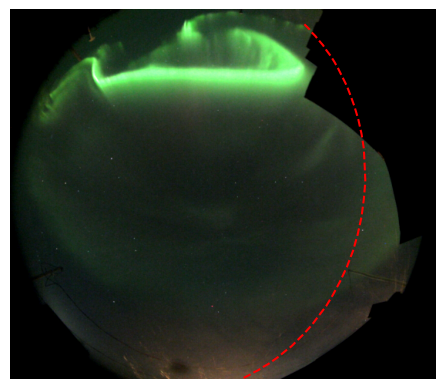

In [22]:
# Custom geomagnetic contour
# ------------------------------
#
# Set altitude we want the contour projected to, and the timestamp. We need the time
# because magnetic coordinates depend on it.
altitude_km = 115
timestamp = data.timestamp[0]

# Define some set of magnetic latitudes and longitudes for our contour
latitudes = np.linspace(59.0, 69.0, 50)
longitudes = -30.0 + (np.sin(np.linspace(0, np.pi / 2, 50)) + 1) * (11 / 2)

# Get the geomagnetic contour in CCD coordinates
ccd_x, ccd_y = at.ccd_contour.mag(skymap_data, timestamp, altitude_km, contour_lats=latitudes, contour_lons=longitudes)

# Plot the image
plt.imshow(scaled_images[:, :, :, 0], origin="lower")
plt.axis("off")

# Plot the contour
plt.plot(ccd_x, ccd_y, color="red", linestyle="--")
plt.show()

Now let's draw a grid of geodetic latitude and longitude contours.

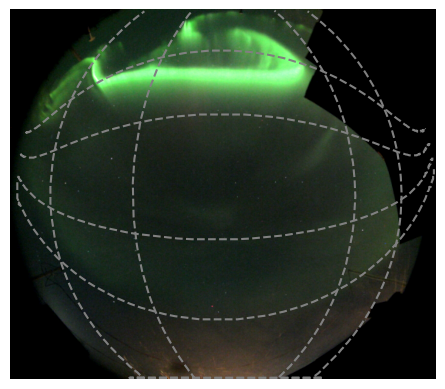

In [23]:
# Set the altitude, and create empty lists to hold a number of arrays defining contours
altitude_km = 115
ccd_x = []
ccd_y = []

# Create a couple different lines of constant latitude
for lat in np.arange(55, 59, 1):
    x_pix, y_pix = at.ccd_contour.geo(skymap_data, altitude_km=altitude_km, constant_lat=lat)
    ccd_x.append(x_pix)
    ccd_y.append(y_pix)

# Create a couple different lines of constant longitude
for i in np.arange(-100, -84, 4):
    x_pix, y_pix = at.ccd_contour.geo(skymap_data, altitude_km=altitude_km, constant_lon=i)
    ccd_x.append(x_pix)
    ccd_y.append(y_pix)

# Plot the image
plt.imshow(scaled_images[:, :, :, 0], origin="lower")
plt.axis("off")

# Iteratively overplot all lines on top
for i in range(len(ccd_x)):
    plt.plot(ccd_x[i], ccd_y[i], color="gray", linestyle="--")

And finally, a grid of magnetic latitude and longitude contours.

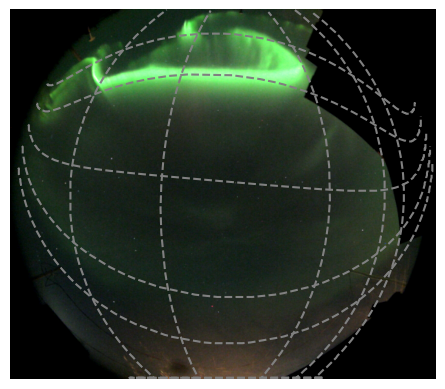

In [24]:
# Set the altitude, and create empty lists to hold a number of arrays defining contours
altitude_km = 115
ccd_x = []
ccd_y = []

# Create a couple different lines of constant latitude
for lat in np.arange(63, 68, 1):
    x_pix, y_pix = at.ccd_contour.mag(skymap_data, data.timestamp[0], altitude_km=altitude_km, constant_lat=lat)
    ccd_x.append(x_pix)
    ccd_y.append(y_pix)

# Create a couple different lines of constant longitude
for i in np.arange(-30, -10, 4):
    x_pix, y_pix = at.ccd_contour.mag(skymap_data, data.timestamp[0], altitude_km=altitude_km, constant_lon=i)
    ccd_x.append(x_pix)
    ccd_y.append(y_pix)

# Plot the image
plt.imshow(scaled_images[:, :, :, 0], origin="lower")
plt.axis("off")

# Iteratively overplot all lines on top
for i in range(len(ccd_x)):
    plt.plot(ccd_x[i], ccd_y[i], color="gray", linestyle="--")